In [1]:
from IPython.display import Audio 
from librosa import display
from matplotlib import pyplot as plt
from pathlib import Path
from ipywidgets import interactive
from mpl_toolkits import mplot3d 
from matplotlib import cm

import glob
import librosa
import numpy as np
import os
import pandas as pd
import scipy
import seaborn as sns
import shutil
import soundfile as sf


file_path_normal = r"../../data/init_data/slider/test/normal_id_00_00000000.wav"
file_path_anomaly = r"../../data/init_data/slider/test/anomaly_id_00_00000000.wav"

samples_normal, sampling_rate_normal = librosa.load(file_path_normal, sr=None, mono=True, offset=0.0, duration=None)
samples_anomaly, sampling_rate_anomaly = librosa.load(file_path_anomaly, sr=None, mono=True, offset=0.0, duration=None)

Dans ce notebook des méthodes permettant la visualisation des sons anormaux et normaux seront implémentées. 

La problématique que l'on cherche a résoudre est la suivante : comment augmenter le nombre d'échantillons d'entrées disponible pour l'entainement de nos réseaux de neurones ?

En effet nous ne disposons actuellement que de quelques milliers d'échantillons par type de machine pour l'entrainement, ce qui peut s'avérer dans certains cas insuffisant.

In [2]:
params = {
    'n_fft': 160*16,
    'frame_step': 160*8,
    'lower_edge_hertz': 0,
    'upper_edge_hertz': 8000,
    'num_mel_bins': 160
}

def logMelSpectrogram(audio, params, fe):

    stfts = librosa.stft(audio,
                        n_fft = int(params['n_fft']),
                        hop_length = int(params["frame_step"]),
                        center = False
                        ).T
    power_spectrograms = np.real(stfts * np.conj(stfts))


    linear_to_mel_weight_matrix = librosa.filters.mel(
                                sr=fe,
                                n_fft=int(params['n_fft']) + 1,
                                n_mels=params['num_mel_bins'],
                                fmin=params['lower_edge_hertz'],
                                fmax=params['upper_edge_hertz']
                    ).T

    mel_spectrograms = np.tensordot(
                power_spectrograms,
                linear_to_mel_weight_matrix,
                1
            )

    return (np.log(mel_spectrograms + 1e-8).astype(np.float16))

def plot_logMelSpectrogram(audio, params, fe, audio_type):
    cmap = sns.color_palette("hot", 100)
    sns.set(style="white")

    fig, ax = plt.subplots(2, 2, figsize=(22,10), gridspec_kw={'width_ratios':[100,5], 'height_ratios':[4, 1] })
    fig.suptitle(f'Extraction {audio_type} Audio', fontsize=26)
    sns.heatmap(np.rot90(logMelSpectrogram(audio, params, fe)), cmap='inferno', ax=ax[0,0], cbar_ax=ax[0,1])
    ax[0, 0].set_title('logMelSpectrogram', fontsize=16)
    ax[0,0].set_ylabel("Frequency (Mel)")
    ax[0,0].set_yticks([])
    ax[0,0].set_xticks([])
    ax[1,1].remove()  # remove unused upper right axes
    librosa.display.waveplot(y=audio, sr=fe, ax=ax[1, 0])
    ax[1, 0].set_title('Audio wave', fontsize=16)
    ax[1, 0].spines['right'].set_visible(False)
    ax[1, 0].spines['top'].set_visible(False)
    


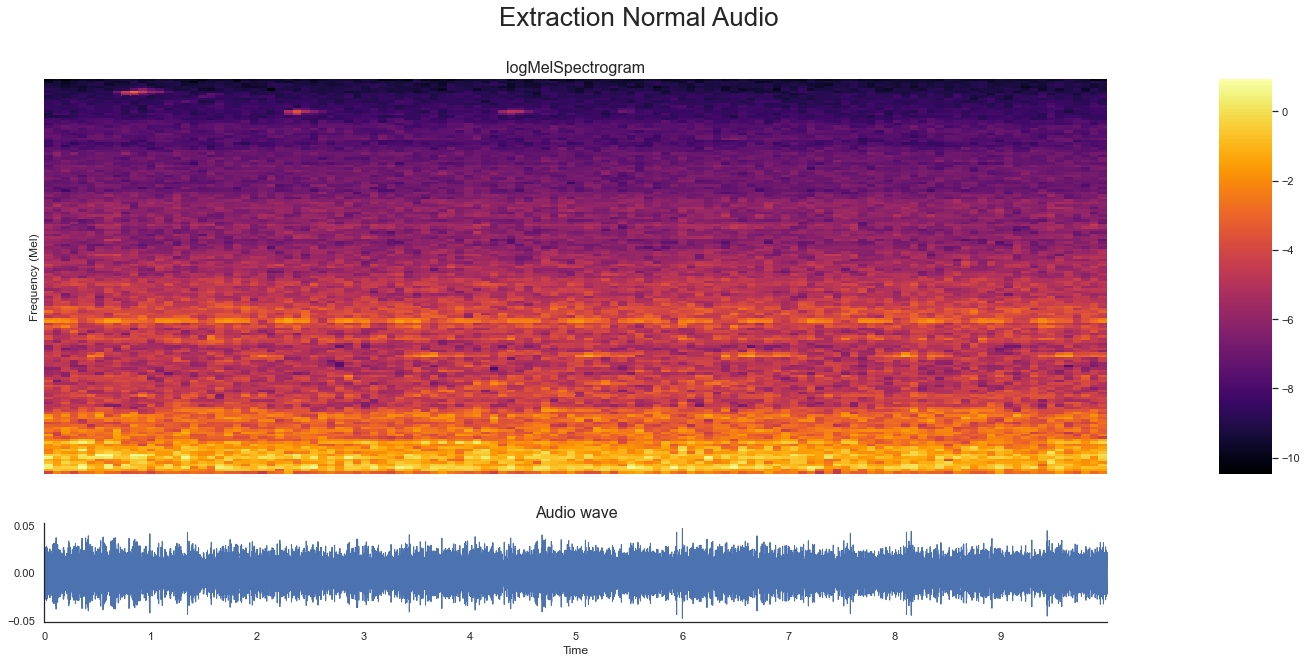

In [3]:
plot_logMelSpectrogram(samples_normal, params, sampling_rate_normal, "Normal")

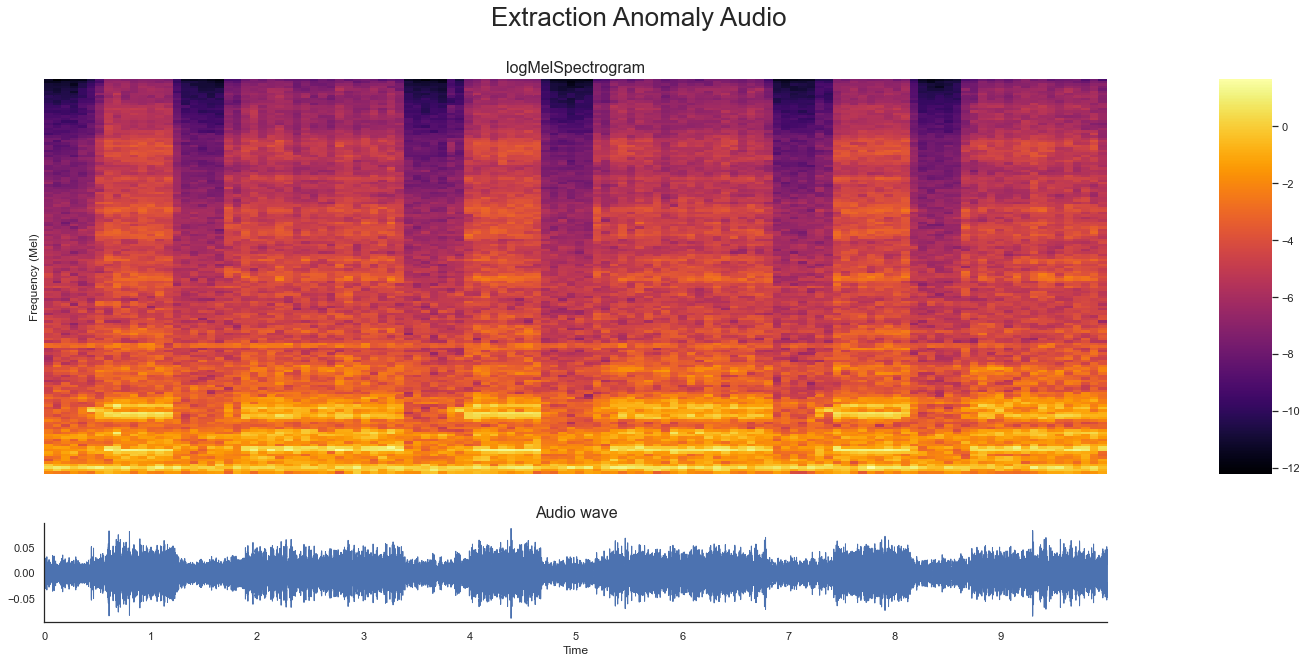

In [4]:
plot_logMelSpectrogram(samples_anomaly, params, sampling_rate_anomaly, "Anomaly")

On remarque que la difference entre son anormaux et normaux semblent etre present sur la totalité de l'echantillon et pas seulement a certains endroits ponctuels. Ceci devrait pouvoir nous permettre de decomposer nos echantillons en un ensemble d'echantillons de durée  inferieure.

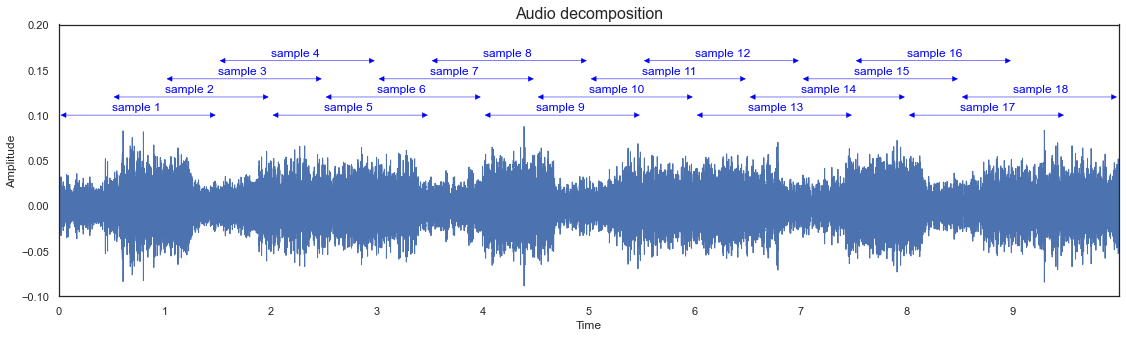

In [5]:
plt.figure(figsize=(19,5))
librosa.display.waveplot(y=samples_anomaly, sr=sampling_rate_normal)
plt.ylabel("Amplitude")
plt.ylim([-0.1, 0.2])

plt.title("Audio decomposition", fontsize=16)

for i in range(18):
    plt.annotate("", xy=(0.5 * i, 0.1 + 0.02 * (i % 4)), xytext=(1.5 + 0.5 * i, 0.1 + 0.02 * (i % 4)), 
                 arrowprops={"color": "blue", "arrowstyle": "<|-|>", "linestyle": "-", "lw":0.5,})
    plt.annotate(f'sample {i+1}', xy = (0.5 + 0.5 * i, 0.105 + 0.02 * (i % 4)), color="blue")


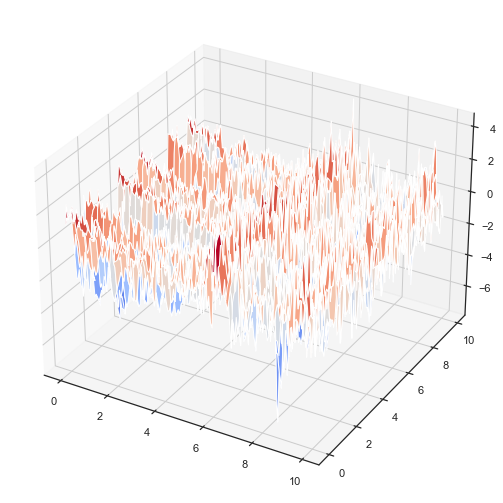

In [6]:
normal_amp = np.rot90(logMelSpectrogram(samples_normal, params, sampling_rate_normal))
anormal_amp = np.rot90(logMelSpectrogram(samples_anomaly, params, sampling_rate_normal))

z = normal_amp - anormal_amp
x = np.zeros(z.shape)
for i in range(160):
    x[i, :] = i/16.
y = np.zeros(z.shape)
for i in range(124):
    y[:, i] = i/12.4

# Creating figyre 
fig = plt.figure(figsize =(14, 9)) 
ax = plt.axes(projection ='3d') 
  
# Creating plot 
ax.plot_surface(x, y, z, cmap=cm.coolwarm) 

Il existe différentes techniques pour augmenter le nombre d'échantillons :

> décomposer les signaux originaux en échantillons de durée inférieure (comme vu précédemment)

> étirer / contracter les échantillons originaux

> superposer un "bruit blanc" sur les échantillons originaux

### Décomposition des échantillons originaux en un ensemble d'échantillons de durée inferieure :

In [7]:
path_decomposition = Path(r"C:\Users\qfich\projet_DS\data\decomposition")
# remove all previous data from decomposition folder
shutil.rmtree(r"C:\Users\qfich\projet_DS\data\decomposition")
for filename in glob.iglob('../../data/init_data/**/**/*.wav'):
    machine_type = Path(filename).parts[-3]
    split_data = Path(filename).parts[-2]
    file_stem = Path(filename).stem
    samples, sampling_rate = librosa.load(filename, sr=None, mono=True, offset=0.0, duration=None)
    for i in range(18):
        new_dir = path_decomposition.joinpath(machine_type, split_data)
        Path(new_dir).mkdir(parents=True, exist_ok=True)
        new_fn = path_decomposition.joinpath(machine_type, split_data, f"{file_stem}_{i+1}.wav")
   
        tot_len = len(samples)
        sf.write(new_fn, samples[int(i * tot_len / 20): int((3 + i) * tot_len / 20)], sampling_rate)

### Etirement / contraction du signal original :

In [8]:
def time_stretch(audio, rate):
    y_stretched = librosa.effects.time_stretch(y=audio, rate = rate)
    return y_stretched

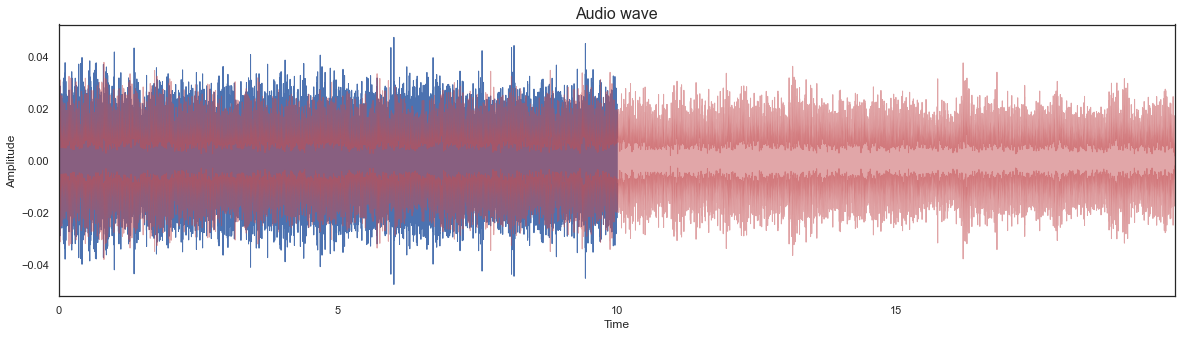

In [9]:
# Exemple : étirement de 50% du signal original

sample_streched = time_stretch(samples_normal, 0.5)

plt.figure(figsize = (20,5))
librosa.display.waveplot(y=samples_normal, sr=sampling_rate_normal, color='b')
librosa.display.waveplot(y=sample_streched, sr=sampling_rate_normal, color='r', alpha = 0.5)
plt.ylabel("Amplitude")
plt.title('Audio wave', fontsize=16);


### Superposition d'un "bruit blanc" sur le signal original :

In [10]:
def random_noise(audio, rate):
    noises = np.random.normal(0,np.max(np.abs(audio))*rate, len(audio))
    return np.array(audio + noises)

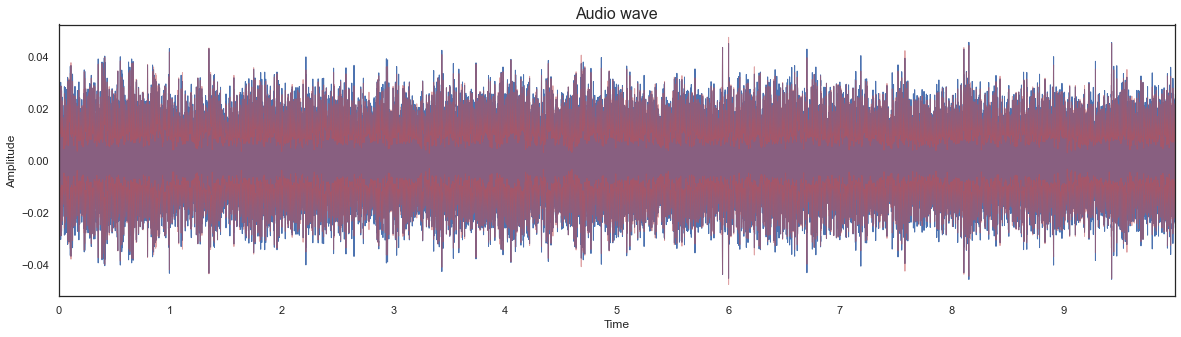

In [11]:
# Exemple : superposition d'un "bruit blanc" équivalent à 5% du signal original

audio_noise = random_noise(audio=samples_normal, rate=0.05)

plt.figure(figsize = (20,5))
librosa.display.waveplot(y=audio_noise, sr=sampling_rate_normal,  color='b')
librosa.display.waveplot(y=samples_normal, sr=sampling_rate_normal, color='r', alpha = 0.5)
plt.ylabel("Amplitude")
plt.title('Audio wave', fontsize=16);
